<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BE_04%5DMakeAlyricist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-04] 작사가 만들기 

In [1]:
import os, re 
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

구글 드라이브 연동

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!mkdir -p lyricist/data/lyrics
!cp /content/gdrive/MyDrive/Data/lyrics.zip /content/lyricist/data/
!unzip -qq '/content/lyricist/data/lyrics.zip' -d /content/lyricist/data/lyrics

In [4]:

txt_file_path = '/content/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


In [5]:
def preprocess_sentence(sentence):
    #입력된 문장을
    # 1. [Chorus] 같은 문장을 지웁니다
    # 2. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    # 3. 특수문자 양쪽에 공백을 넣고
    # 4. 여러개의 공백은 하나의 공백으로 바꿉니다
    # 5. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    # 6. 다시 양쪽 공백을 지웁니다
    # 7. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    
    sentence = re.sub(r'\[[^)]*\]',r'',sentence ) # 1
    sentence = sentence.lower().strip() # 2
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 3
    sentence = re.sub(r'[" "]+', " ", sentence) # 4
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 5
    sentence = sentence.strip() # 6
    if sentence : 
      sentence = '<start> ' + sentence + ' <end>' # 7
      return sentence


print(preprocess_sentence("[Chorus]HiHi my name is mk~!~!"))

<start> hihi my name is mk ! ! <end>


In [6]:
corpus = []
for sentence in raw_corpus:
    
    if len(sentence) == 0: continue
    
    # 정제를 해주세요 
    preprocessed_sentence = preprocess_sentence(sentence)

    # 정제를 하고 났을때 그냥 빈 (<start><end>) sentence 들은 빼주세요! 
    if not preprocessed_sentence : continue
    
    #preprocessing 하고 나서 15개 이상인 것들만 담아 줬어요
    if len(preprocessed_sentence.split(' ')) > 15 : continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 '<start> i don t even wanna waste your time <end>',
 '<start> let s just say that maybe <end>',
 '<start> you could help me ease my mind <end>',
 '<start> if that s love in your eyes <end>',
 '<start> it s more than enough <end>',
 '<start> had some bad love <end>',
 '<start> ooh , ooh looking for some affirmation <end>']

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words= 20000,                  #단어장 크기는 12,000 이상!
        filters=' ',
        oov_token="<unk>"
    )
    # 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)  
    print(tensor) 
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[  2 290  28 ...   0   0   0]
 [  2 219  13 ...   0   0   0]
 [  2  25  15 ...   0   0   0]
 ...
 [  2   6 458 ...  26 205   3]
 [  2   8  41 ...   0   0   0]
 [  2   4  92 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f9a28667990>


In [8]:
tensor[0]
tensor.shape

(155717, 15)

In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2  290   28   94 4472    3    0    0    0    0    0    0    0    0]
[ 290   28   94 4472    3    0    0    0    0    0    0    0    0    0]


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input,test_size=0.2, random_state=42)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)


val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(train_dataset)
print(val_dataset)

Source Train: (124573, 14)
Target Train: (124573, 14)
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


In [22]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        #self.bidirectional_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size,  return_sequences=True))
        #self.bidirectional_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size//2,  return_sequences=True))
        #self.linear_1 = tf.keras.layers.Dense(64, activation='relu')
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, stateful=True,
                        recurrent_initializer='glorot_uniform')
        #self.dropout_1 = tf.keras.layers.Dropout(0.5)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        #self.dropout_2 = tf.keras.layers.Dropout(0.5)
        self.linear_2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        #out = self.bidirectional_1(out)
        #out = self.bidirectional_2(out)
        #out = self.linear_1(out)
        out = self.rnn_1(out)
        #out = self.dropout_1(out)
        out = self.rnn_2(out)
        #out = self.dropout_2(out)
        out = self.linear_2(out)

        
        return out
    
embedding_size = 512 #256
hidden_size = 1024 #1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)


# 

In [23]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 20001), dtype=float32, numpy=
array([[[-5.97928411e-05,  4.68720275e-04,  1.83206605e-04, ...,
          7.63900971e-05,  1.61503442e-04,  1.70653308e-04],
        [-4.44215257e-04,  9.06070170e-04,  2.61260284e-04, ...,
          2.02253359e-04,  6.55150448e-04, -5.52685560e-05],
        [-3.54783202e-04,  1.25219533e-03,  7.55967540e-06, ...,
          4.50817053e-04,  8.54505168e-04, -2.16904111e-04],
        ...,
        [-6.71780494e-04, -1.19780586e-03, -1.42205763e-03, ...,
          3.71088390e-04,  2.26000207e-04,  2.85110636e-05],
        [-8.94619210e-04, -1.80343108e-03, -1.07517536e-03, ...,
          3.57487821e-04,  2.79753236e-04,  1.97658635e-04],
        [-1.12312334e-03, -2.36129877e-03, -7.69935374e-04, ...,
          2.66625662e-04,  3.31013143e-04,  3.63632193e-04]],

       [[-5.97928411e-05,  4.68720275e-04,  1.83206605e-04, ...,
          7.63900971e-05,  1.61503442e-04,  1.70653308e-04],
        [-1.46228384e-04,  1.03930943e-03,  4

In [25]:
model.summary() #2.5061

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  10240512  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  6295552   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_2 (Dense)              multiple                  20501025  
Total params: 45,429,793
Trainable params: 45,429,793
Non-trainable params: 0
_________________________________________________________________


In [26]:

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
486/486 [==============================] - 176s 357ms/step - loss: 3.3347 - accuracy: 0.5007 - val_loss: 3.0493 - val_accuracy: 0.5226
Epoch 2/10
486/486 [==============================] - 173s 356ms/step - loss: 2.9053 - accuracy: 0.5294 - val_loss: 2.8758 - val_accuracy: 0.5343
Epoch 3/10
486/486 [==============================] - 173s 356ms/step - loss: 2.6890 - accuracy: 0.5431 - val_loss: 2.7510 - val_accuracy: 0.5467
Epoch 4/10
486/486 [==============================] - 173s 356ms/step - loss: 2.5001 - accuracy: 0.5590 - val_loss: 2.6638 - val_accuracy: 0.5580
Epoch 5/10
486/486 [==============================] - 180s 371ms/step - loss: 2.3332 - accuracy: 0.5760 - val_loss: 2.5937 - val_accuracy: 0.5694
Epoch 6/10
486/486 [==============================] - 173s 356ms/step - loss: 2.1865 - accuracy: 0.5938 - val_loss: 2.5363 - val_accuracy: 0.5801
Epoch 7/10
486/486 [==============================] - 173s 355ms/step - loss: 2.0549 - accuracy: 0.6117 - val_loss: 2.4951 -

In [ ]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [21]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

ValueError: ignored

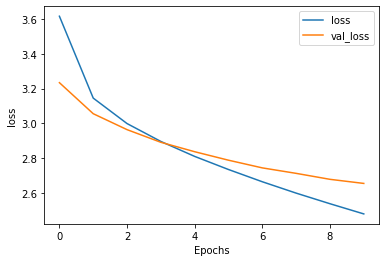

In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
plot_graphs(history, 'loss')

In [ ]:
while True:pass

*set의 원소는 iterator를 만들어서 next로 가져온다...
set은 시퀀스 자료형 이아니기 때문에 인덱싱이 안된다~!~!

In [52]:
model.summary() #2.5061

Model: "text_generator_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     multiple                  10240512  
_________________________________________________________________
lstm_18 (LSTM)               multiple                  6295552   
_________________________________________________________________
dropout_15 (Dropout)         multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  20501025  
Total params: 37,037,089
Trainable params: 37,037,089
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.summary()     #2.4497

Model: "text_generator_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  10240512  
_________________________________________________________________
lstm_17 (LSTM)               multiple                  6295552   
_________________________________________________________________
dense_15 (Dense)             multiple                  20501025  
Total params: 37,037,089
Trainable params: 37,037,089
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.summary()    #2.6248 

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  10240512  
_________________________________________________________________
lstm_2 (LSTM)                multiple                  6295552   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  20501025  
Total params: 45,429,793
Trainable params: 45,429,793
Non-trainable params: 0
______________________________________